In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
import cPickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve

In [13]:
## loading data using Pandas

messages = pandas.read_csv('C:\Users\dell\Documents\Python Scripts\sms_spam.csv', names=["label", "message"])
print messages

     label                                            message
0     type                                               text
1      ham  Go until jurong point, crazy.. Available only ...
2      ham                      Ok lar... Joking wif u oni...
3     spam  Free entry in 2 a wkly comp to win FA Cup fina...
4      ham  U dun say so early hor... U c already then say...
5      ham  Nah I don't think he goes to usf, he lives aro...
6     spam  FreeMsg Hey there darling it's been 3 week's n...
7      ham  Even my brother is not like to speak with me. ...
8      ham  As per your request 'Melle Melle (Oru Minnamin...
9     spam  WINNER!! As a valued network customer you have...
10    spam  Had your mobile 11 months or more? U R entitle...
11     ham  I'm gonna be home soon and i don't want to tal...
12    spam  SIX chances to win CASH! From 100 to 20,000 po...
13    spam  URGENT! You have won a 1 week FREE membership ...
14     ham  I've been searching for the right words to tha...
15     h

In [14]:
## To get pivot of dataset

messages.groupby('label').describe()

message
label                                                          
ham   count                                                4827
      unique                                               4518
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                642
      top     Please call our customer service representativ...
      freq                                                    4
type  count                                                   1
      unique                                                  1
      top                                                  text
      freq                                                    1

In [15]:
## adding extra column to get the length of the text

messages['length'] = messages['message'].map(lambda text: len(text))
print messages.head()

  label                                            message  length
0  type                                               text       4
1   ham  Go until jurong point, crazy.. Available only ...     111
2   ham                      Ok lar... Joking wif u oni...      29
3  spam  Free entry in 2 a wkly comp to win FA Cup fina...     155
4   ham  U dun say so early hor... U c already then say...      49


count    5575.000000
mean       80.549955
std        59.911201
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

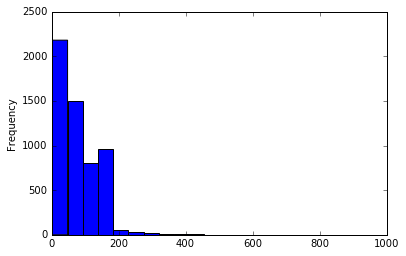

In [16]:
## plotting

messages.length.plot(bins=20, kind='hist')

messages.length.describe()

In [17]:
## to check the longest messages

print list(messages.message[messages.length > 900])

["For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000124ADEB8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000012785860>]], dtype=object)

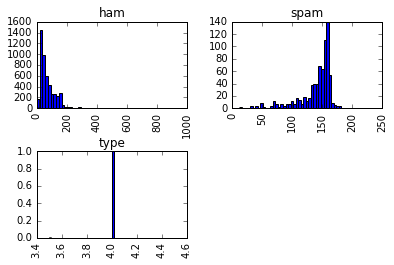

In [18]:
## checking out the difference between ham and spam

messages.hist(column='length', by='label', bins=50)

In [19]:
## Data Preprocessing

## we'll use the bag-of-words approach, where each unique word in a text will be represented by one number.

## splitting it into tokens

def split_into_tokens(message):
    message = unicode(message, 'utf8')  # convert bytes into proper unicode
    return TextBlob(message).words


In [20]:
## original text

messages.message.head()

0                                                 text
1    Go until jurong point, crazy.. Available only ...
2                        Ok lar... Joking wif u oni...
3    Free entry in 2 a wkly comp to win FA Cup fina...
4    U dun say so early hor... U c already then say...
Name: message, dtype: object

In [21]:
## now text after tokenized

messages.message.head().apply(split_into_tokens)

0                                               [text]
1    [Go, until, jurong, point, crazy, Available, o...
2                       [Ok, lar, Joking, wif, u, oni]
3    [Free, entry, in, 2, a, wkly, comp, to, win, F...
4    [U, dun, say, so, early, hor, U, c, already, t...
Name: message, dtype: object

In [22]:
## Part of speech tag (POS)

TextBlob("Hello world, how is it going?").tags  # list of (word, POS) pairs

[('Hello', u'NNP'),
 ('world', u'NN'),
 ('how', u'WRB'),
 ('is', u'VBZ'),
 ('it', u'PRP'),
 ('going', u'VBG')]

In [23]:
## lemmatizing --- normalize words into their base form

def split_into_lemmas(message):
    message = unicode(message, 'utf8').lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

messages.message.head().apply(split_into_lemmas)

0                                               [text]
1    [go, until, jurong, point, crazy, available, o...
2                       [ok, lar, joking, wif, u, oni]
3    [free, entry, in, 2, a, wkly, comp, to, win, f...
4    [u, dun, say, so, early, hor, u, c, already, t...
Name: message, dtype: object

In [24]:
## Data to Vectors

# Now we'll convert each message, represented as a list of tokens (lemmas) above, 
# into a vector that machine learning models can understand.

# Doing that requires essentially three steps, in the bag-of-words model:

# 1. counting how many times does a word occur in each message (term frequency)
# 2. weighting the counts, so that frequent tokens get lower weight (inverse document frequency)
# 3. normalizing the vectors to unit length, to abstract from the original text length (L2 norm)

# Each vector has as many dimensions as there are unique words in the SMS corpus:

bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(messages['message'])
print len(bow_transformer.vocabulary_)


8856


In [25]:
# Here we used `scikit-learn` (`sklearn`), a powerful Python library for teaching machine learning. 
# It contains a multitude of various methods and options.

# Let's take one text message and get its bag-of-words counts as a vector, putting to use our new `bow_transformer`:

## Feature Engineering

message4 = messages['message'][3]
print message4

Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


In [26]:
bow4 = bow_transformer.transform([message4])
print bow4
print bow4.shape

  (0, 23)	2
  (0, 105)	1
  (0, 454)	1
  (0, 474)	1
  (0, 486)	1
  (0, 895)	1
  (0, 950)	1
  (0, 1274)	1
  (0, 1900)	1
  (0, 2266)	1
  (0, 2478)	1
  (0, 3042)	2
  (0, 3173)	2
  (0, 3283)	1
  (0, 3433)	1
  (0, 4179)	1
  (0, 5018)	1
  (0, 6286)	1
  (0, 6339)	1
  (0, 6397)	1
  (0, 7298)	1
  (0, 7521)	1
  (0, 7635)	1
  (0, 7788)	1
  (0, 7799)	3
  (0, 7983)	1
  (0, 8470)	1
  (0, 8510)	1
(1, 8856)


In [27]:
# So, nine unique words in message nr. 4, two of them appear twice, the rest only once. 
# lets check what are these words the appear twice?

print bow_transformer.get_feature_names()[6736]
print bow_transformer.get_feature_names()[8013]

scary
ugo


In [28]:
messages_bow = bow_transformer.transform(messages['message'])
print 'sparse matrix shape:', messages_bow.shape
print 'number of non-zeros:', messages_bow.nnz
print 'sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))

sparse matrix shape: (5575, 8856)
number of non-zeros: 80296
sparsity: 0.16%


In [29]:
# And finally, after the counting, the term weighting and normalization 
# can be done with [TF-IDF] using scikit-learn's `TfidfTransformer`:

tfidf_transformer = TfidfTransformer().fit(messages_bow)
tfidf4 = tfidf_transformer.transform(bow4)
print tfidf4

  (0, 8510)	0.179669605219
  (0, 8470)	0.138220047641
  (0, 7983)	0.118193846426
  (0, 7799)	0.171057289711
  (0, 7788)	0.208201289691
  (0, 7635)	0.112791172603
  (0, 7521)	0.133720066956
  (0, 7298)	0.185464790166
  (0, 6397)	0.157664721917
  (0, 6339)	0.157664721917
  (0, 6286)	0.158417547335
  (0, 5018)	0.148401638785
  (0, 4179)	0.0764281678015
  (0, 3433)	0.109109928158
  (0, 3283)	0.173530433012
  (0, 3173)	0.442935534945
  (0, 3042)	0.339446088525
  (0, 2478)	0.190199801038
  (0, 2266)	0.185464790166
  (0, 1900)	0.119697391163
  (0, 1274)	0.159992008679
  (0, 950)	0.0644135303412
  (0, 895)	0.208201289691
  (0, 486)	0.213996474639
  (0, 474)	0.213996474639
  (0, 454)	0.094462180765
  (0, 105)	0.221467767473
  (0, 23)	0.18267653968


In [30]:
# To check what is the IDF (inverse document frequency) of the word `"u"`? Of word `"university"`?

print tfidf_transformer.idf_[bow_transformer.vocabulary_['u']]
print tfidf_transformer.idf_[bow_transformer.vocabulary_['university']]

2.8508608615
8.23993259132


In [31]:
# To transform the entire bag-of-words corpus into TF-IDF corpus at once:

messages_tfidf = tfidf_transformer.transform(messages_bow)
print messages_tfidf.shape

(5575, 8856)


In [32]:
## Training a model
# We'll be using scikit-learn here, choosing the [Naive Bayes](http://en.wikipedia.org/wiki/Naive_Bayes_classifier) 
# classifier to start with:

%time spam_detector = MultinomialNB().fit(messages_tfidf, messages['label'])

Wall time: 106 ms


In [33]:
# Let's try classifying our single random message:

print 'predicted:', spam_detector.predict(tfidf4)[0]
print 'expected:', messages.label[3]

predicted: spam
expected: spam


In [34]:
all_predictions = spam_detector.predict(messages_tfidf)
print all_predictions

['ham' 'ham' 'ham' ..., 'ham' 'ham' 'ham']


accuracy 0.96932735426
confusion matrix
[[4827    0    0]
 [ 170  577    0]
 [   1    0    0]]
(row=expected, col=predicted)


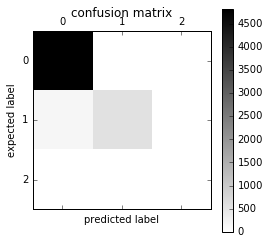

In [35]:
## Calculating accuracy and confusion matrix on Training data which will definitely give good accuracy

print 'accuracy', accuracy_score(messages['label'], all_predictions)
print 'confusion matrix\n', confusion_matrix(messages['label'], all_predictions)
print '(row=expected, col=predicted)'

plt.matshow(confusion_matrix(messages['label'], all_predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [36]:
print classification_report(messages['label'], all_predictions)

             precision    recall  f1-score   support

        ham       0.97      1.00      0.98      4827
       spam       1.00      0.77      0.87       747
       type       0.00      0.00      0.00         1

avg / total       0.97      0.97      0.97      5575



C:\Users\dell\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [37]:
## splitting the data into training and testing

msg_train, msg_test, label_train, label_test = \
    train_test_split(messages['message'], messages['label'], test_size=0.2)

print len(msg_train), len(msg_test), len(msg_train) + len(msg_test)

4460 1115 5575


In [ ]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [ ]:
## Cross Validation

# A common practice is to partition the training set again, into smaller subsets; for example, 5 equally sized subsets. 
# Then we train the model on four parts, and compute accuracy on the last part (called "validation set"). 
# Repeated five times (taking different part for evaluation each time), we get a sense of model "stability". 
# If the model gives wildly different scores for different subsets, it's a sign something is wrong (bad data, or bad model variance). 
# Go back, analyze errors, re-check input data for garbage, re-check data cleaning.

scores = cross_val_score(pipeline,  # steps to convert raw messages into models
                         msg_train,  # training data
                         label_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print scores

C:\Users\dell\Anaconda2\lib\site-packages\sklearn\cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


In [ ]:
print scores.mean(), scores.std()

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
%time plot_learning_curve(pipeline, "accuracy vs. training set size", msg_train, label_train, cv=5)

In [ ]:
# At this point, we have two options:

# 1. use more training data, to overcome low model complexity
# 2. use a more complex (lower bias) model to start with, to get more out of the existing data

params = {
    'tfidf__use_idf': (True, False),
    'bow__analyzer': (split_into_lemmas, split_into_tokens),
}

grid = GridSearchCV(
    pipeline,  # pipeline from above
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(label_train, n_folds=5),  # what type of cross validation to use
)



In [ ]:
%time nb_detector = grid.fit(msg_train, label_train)
print nb_detector.grid_scores_

In [ ]:
print nb_detector.predict_proba(["Hi mom, how are you?"])[0]
print nb_detector.predict_proba(["WINNER! Credit for free!"])[0]

In [ ]:
print nb_detector.predict(["Hi mom, how are you?"])[0]
print nb_detector.predict(["WINNER! Credit for free!"])[0]

In [ ]:
# And overall scores on the test set, the one we haven't used at all during training

predictions = nb_detector.predict(msg_test)
print confusion_matrix(label_test, predictions)
print classification_report(label_test, predictions)

In [ ]:
#############################################################################################################

################## SVM #########################################

pipeline_svm = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC()),  # <== change here
])

# pipeline parameters to automatically explore and tune
param_svm = [
  {'classifier__C': [1, 10, 100, 1000], 'classifier__kernel': ['linear']},
  {'classifier__C': [1, 10, 100, 1000], 'classifier__gamma': [0.001, 0.0001], 'classifier__kernel': ['rbf']},
]

grid_svm = GridSearchCV(
    pipeline_svm,  # pipeline from above
    param_grid=param_svm,  # parameters to tune via cross validation
    refit=True,  # fit using all data, on the best detected classifier
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(label_train, n_folds=5),  # what type of cross validation to use
)

In [ ]:
%time svm_detector = grid_svm.fit(msg_train, label_train) # find the best combination from param_svm
print svm_detector.grid_scores_

In [ ]:
print svm_detector.predict(["Hi mom, how are you?"])[0]
print svm_detector.predict(["WINNER! Credit for free!"])[0]

In [ ]:
print confusion_matrix(label_test, svm_detector.predict(msg_test))
print classification_report(label_test, svm_detector.predict(msg_test))

In [ ]:
print confusion_matrix(label_test, svm_detector.predict(msg_test))
print classification_report(label_test, svm_detector.predict(msg_test))

In [ ]:
## Productionalizing a predictor

# store the spam detector to disk after training
with open('sms_spam_detector.pkl', 'wb') as fout:
    cPickle.dump(svm_detector, fout)

# ...and load it back, whenever needed, possibly on a different machine
svm_detector_reloaded = cPickle.load(open('sms_spam_detector.pkl'))

In [ ]:
print 'before:', svm_detector.predict([message4])[0]
print 'after:', svm_detector_reloaded.predict([message4])[0]